# Prediction of Pulsars and Non-pulsars via Classification - Project Report

## Group 10 Members
- Nishant Molleti:   21147343
- Ajitesh Taneja: &nbsp; 69832913
- Asteria Xu: &nbsp; &nbsp; &nbsp; &nbsp; 56376452
- Audrey Tsung: &nbsp; 60770633

## Introduction

Pulsars are rotating neutron stars that emit radio waves at regular intervals, and their detection is important in fields such as Astrophysics and Radio Astronomy. However, pulsars are challenging to detect due to interference and noise at radio frequencies, thus giving false signals. To improve detection, machine learning techniques have been employed. 

The question that we want to address is: Is a new observation a pulsar or non-pulsar based on the statistics of the integrated profile as our predictors? 

The dataset which we are using to answer this question is the HTRU2 dataset, which contains 17,898 observations of pulsars and non-pulsars, obtained from the High Time Resolution Universe Survey. Each observation has 8 features; mean, standard deviation, excess kurtosis and skewness for both the Integrated Profile and DM-SNR curve. Additionally, a binary label called 'class' is used to indicate whether an observation is a pulsar or not where 0 belongs to non-pulsar and 1 being pulsar. 


In [1]:
library(tidyverse)
library(repr)
library(recipes)
library(tidymodels)
library(cowplot)
library(GGally)
library(tidymodels)
library(ggplot2)
install.packages("themis")
library("themis")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::fil

## Preliminary Exploratory Data Analysis

Now, we will read the dataset from the web into R, and then clean our data.  Here, we notice that the class column has 0's and 1's. The 1's mean that the observation is a pulsar, and 0 means non-pulsar.

In [3]:
# Adding the column names to the dataset because they originally did not exist
columns <- c("mean_ip", "std_ip", "ek_ip", "sk_ip", "mean_dmsnr", "std_dmsnr", "ek_dmsnr", "sk_dmsnr", "class")

# reading the data, and converting class to factor type
pulsar_data <- read_csv("https://raw.githubusercontent.com/audst/dsci100-s005-group10/main/data/HTRU_2.csv", col_names = columns) |>
                    mutate(class = as.factor(class))

print("Table 1")
head(pulsar_data, 10)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_ip, std_ip, ek_ip, sk_ip, mean_dmsnr, std_dmsnr, ek_dmsnr, sk_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1"


mean_ip,std_ip,ek_ip,sk_ip,mean_dmsnr,std_dmsnr,ek_dmsnr,sk_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,0


Next, we can select the columns that we plan to use as the predictors, namely mean_ip, std_ip, ek_ip, and sk_ip, along with the class column.

In [4]:
pulsar_data_pred <- pulsar_data |>
                        select(mean_ip, std_ip, ek_ip, sk_ip, class)

print("Table 2")
head(pulsar_data_pred, 5)

[1] "Table 2"


mean_ip,std_ip,ek_ip,sk_ip,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,0
102.50781,58.88243,0.46531815,-0.5150879,0
103.01562,39.34165,0.32332837,1.0511644,0
136.75000,57.17845,-0.06841464,-0.6362384,0
88.72656,40.67223,0.60086608,1.1234917,0


We now have to scale all the potential predictor variables so that the prediction is not influenced by the different scales of all the predictors, thus avoiding inaccurate predictions.

In [5]:
pulsar_scaled <- pulsar_data_pred |>
                    mutate(mean_ip_scaled = scale(mean_ip, center=TRUE)) |>
                    mutate(std_ip_scaled = scale(std_ip, center=TRUE)) |>
                    mutate(ek_ip_scaled = scale(ek_ip, center=TRUE)) |>
                    mutate(sk_ip_scaled = scale(sk_ip, center=TRUE)) |>
                    select(class:sk_ip_scaled)

print("Table 3")
head(pulsar_scaled, 10)

[1] "Table 3"


class,mean_ip_scaled,std_ip_scaled,ek_ip_scaled,sk_ip_scaled
<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0,1.1492849,1.33479435,-0.66955083,-0.40044782
0,-0.3341589,1.80221498,-0.01178443,-0.37052514
0,-0.3143634,-1.05329280,-0.14522850,-0.11658960
0,1.0006664,1.55321102,-0.51339427,-0.39016719
0,-0.8713781,-0.85885481,0.11560548,-0.10486323
0,-0.6825595,0.02171238,0.05079471,-0.21945151
0,0.3276197,0.32375660,-0.41953043,-0.30519991
0,0.7524614,-0.97987584,-0.59789123,-0.22385830
0,-0.1492994,0.88811611,-0.02365441,-0.25939593


Now we can continue with splitting 75% of our data into training and and 25% testing.

In [6]:
set.seed(100)

pulsar_split <- pulsar_scaled |>
                    initial_split(prop=3/4, strata=class)
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

We can now see if we have any missing data in our training set

In [7]:
n_rows_missing_data <- pulsar_training |>
                          map_df(~sum(is.na(.)))

print("Table 4")
n_rows_missing_data

[1] "Table 4"


class,mean_ip_scaled,std_ip_scaled,ek_ip_scaled,sk_ip_scaled
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


Fortunately, we can see that we do not have empty data to deal with, so we can proceed to find out how many observations exist for each class in our training set.

In [8]:
class_counts <- pulsar_training |>
                    group_by(class) |>
                    dplyr::summarize(count = n())

print("Table 5")
class_counts

[1] "Table 5"


class,count
<fct>,<int>
0,12182
1,1241


Here, we notice that there is an overwhelming majority of observations with class 0, which shows how difficult it is to detect pulsars among the rest of the noise and radio frequencies. 
Now we find the means of all our predictor variables based on the two classes.

In [9]:
means <- pulsar_training |>
            group_by(class) |>
            summarize_at(vars("mean_ip_scaled", "std_ip_scaled", "ek_ip_scaled", "sk_ip_scaled"), mean)

print("Table 6")
means

[1] "Table 6"


class,mean_ip_scaled,std_ip_scaled,ek_ip_scaled,sk_ip_scaled
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.2081899,0.116493,-0.2499686,-0.2245242
1,-2.1213040,-1.137280,2.4894519,2.2201626


Above, we see that the means of the variables vary extensively for the different classes. This reaffirms our choice of predictor variables as the model will be able to predict the different classes with a greater accuracy and less indistinctness. 
Now we can create a series of plots to find out the relation of the different variables with the class. Each plot matches one predictor variable with another to demonstrate any visual trends that are otherwise unnoticeable. 

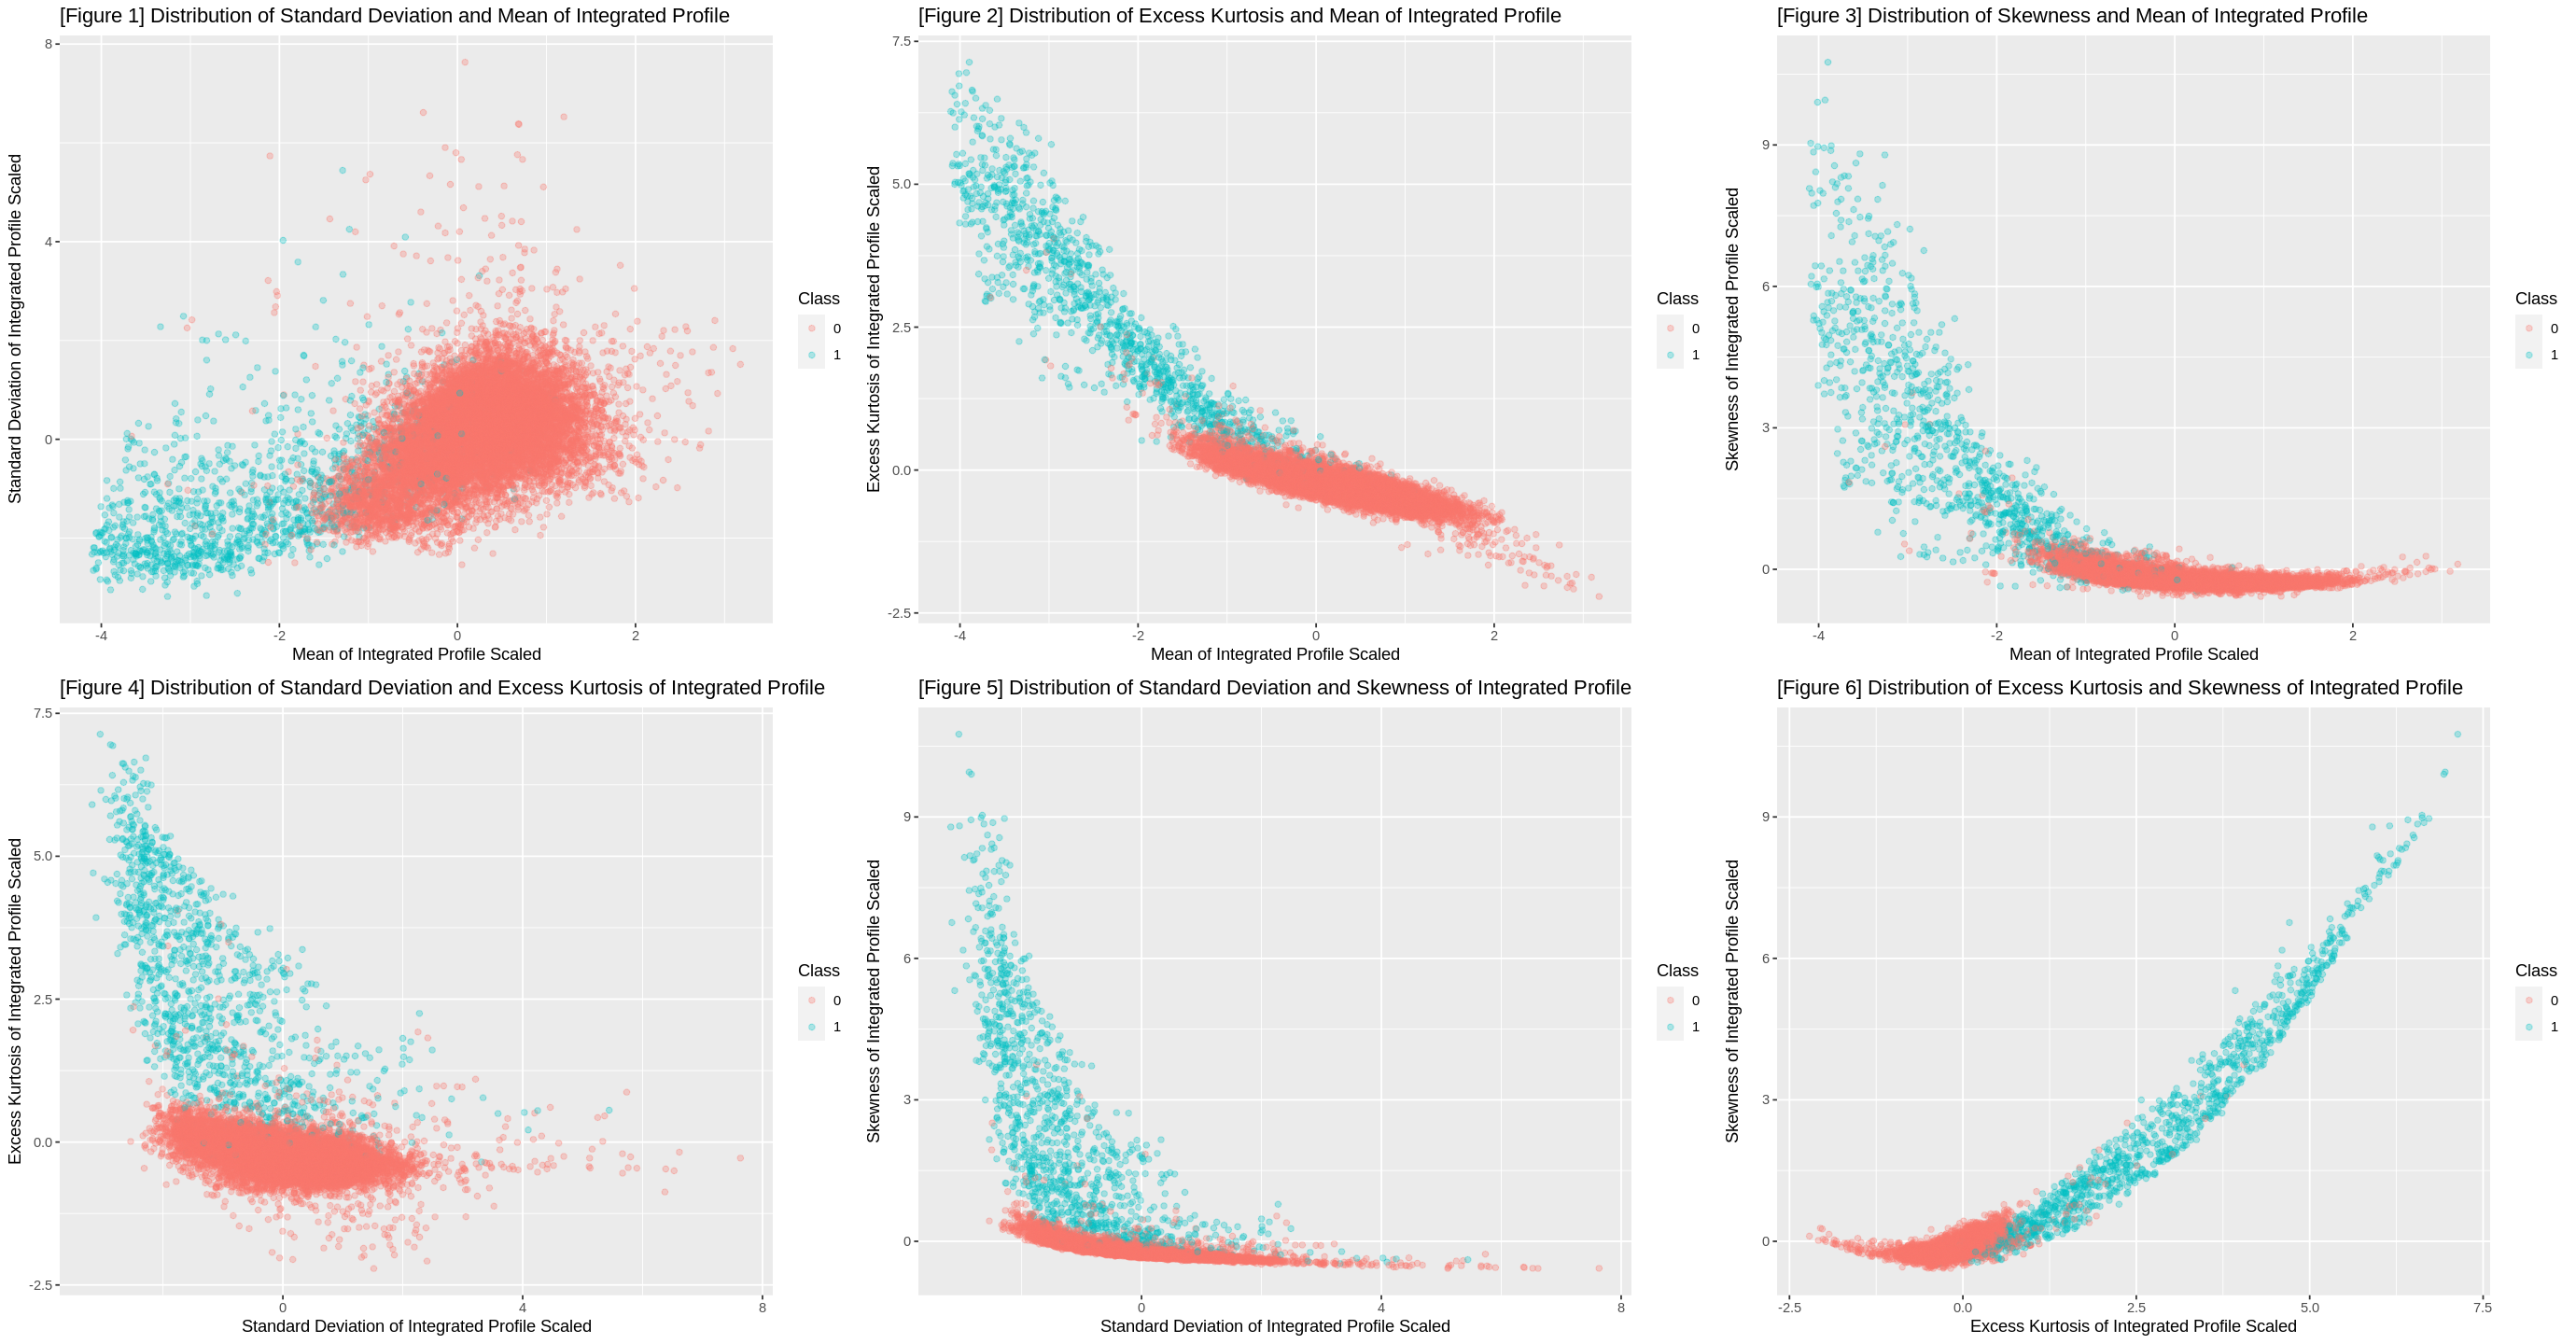

In [10]:
options(repr.plot.width = 23, repr.plot.height = 12)

mean_ip_vs_std_ip <- pulsar_training |>
                        ggplot(aes(x=mean_ip_scaled, y=std_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Mean of Integrated Profile Scaled", 
                             y="Standard Deviation of Integrated Profile Scaled", 
                             color="Class", 
                             title="[Figure 1] Distribution of Standard Deviation and Mean of Integrated Profile") +
                        theme(text = element_text(size = 11))

mean_ip_vs_ek_ip <- pulsar_training |>
                        ggplot(aes(x=mean_ip_scaled, y=ek_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Mean of Integrated Profile Scaled", 
                             y="Excess Kurtosis of Integrated Profile Scaled", 
                             color="Class", 
                             title="[Figure 2] Distribution of Excess Kurtosis and Mean of Integrated Profile") +
                        theme(text = element_text(size = 11))

mean_ip_vs_sk_ip <- pulsar_training |>
                        ggplot(aes(x=mean_ip_scaled, y=sk_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Mean of Integrated Profile Scaled", 
                             y="Skewness of Integrated Profile Scaled", 
                             color="Class", 
                             title="[Figure 3] Distribution of Skewness and Mean of Integrated Profile") +
                        theme(text = element_text(size = 11))

std_ip_vs_ek_ip <- pulsar_training |>
                        ggplot(aes(x=std_ip_scaled, y=ek_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Standard Deviation of Integrated Profile Scaled", 
                             y="Excess Kurtosis of Integrated Profile Scaled", 
                             color="Class", 
                             title="[Figure 4] Distribution of Standard Deviation and Excess Kurtosis of Integrated Profile") +
                        theme(text = element_text(size = 11))

std_ip_vs_sk_ip <- pulsar_training |>
                        ggplot(aes(x=std_ip_scaled, y=sk_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Standard Deviation of Integrated Profile Scaled", 
                             y="Skewness of Integrated Profile Scaled", 
                             color="Class", 
                             title="[Figure 5] Distribution of Standard Deviation and Skewness of Integrated Profile") +
                        theme(text = element_text(size = 11))

ek_ip_vs_sk_ip <- pulsar_training |>
                        ggplot(aes(x=ek_ip_scaled, y=sk_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Excess Kurtosis of Integrated Profile Scaled", 
                             y="Skewness of Integrated Profile Scaled", 
                             color="Class", 
                             title="[Figure 6] Distribution of Excess Kurtosis and Skewness of Integrated Profile") +
                        theme(text = element_text(size = 11))

plot_grid(
     mean_ip_vs_std_ip, mean_ip_vs_ek_ip, mean_ip_vs_sk_ip, std_ip_vs_ek_ip, std_ip_vs_sk_ip, ek_ip_vs_sk_ip,  
     align="hv"
 )

NULL

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



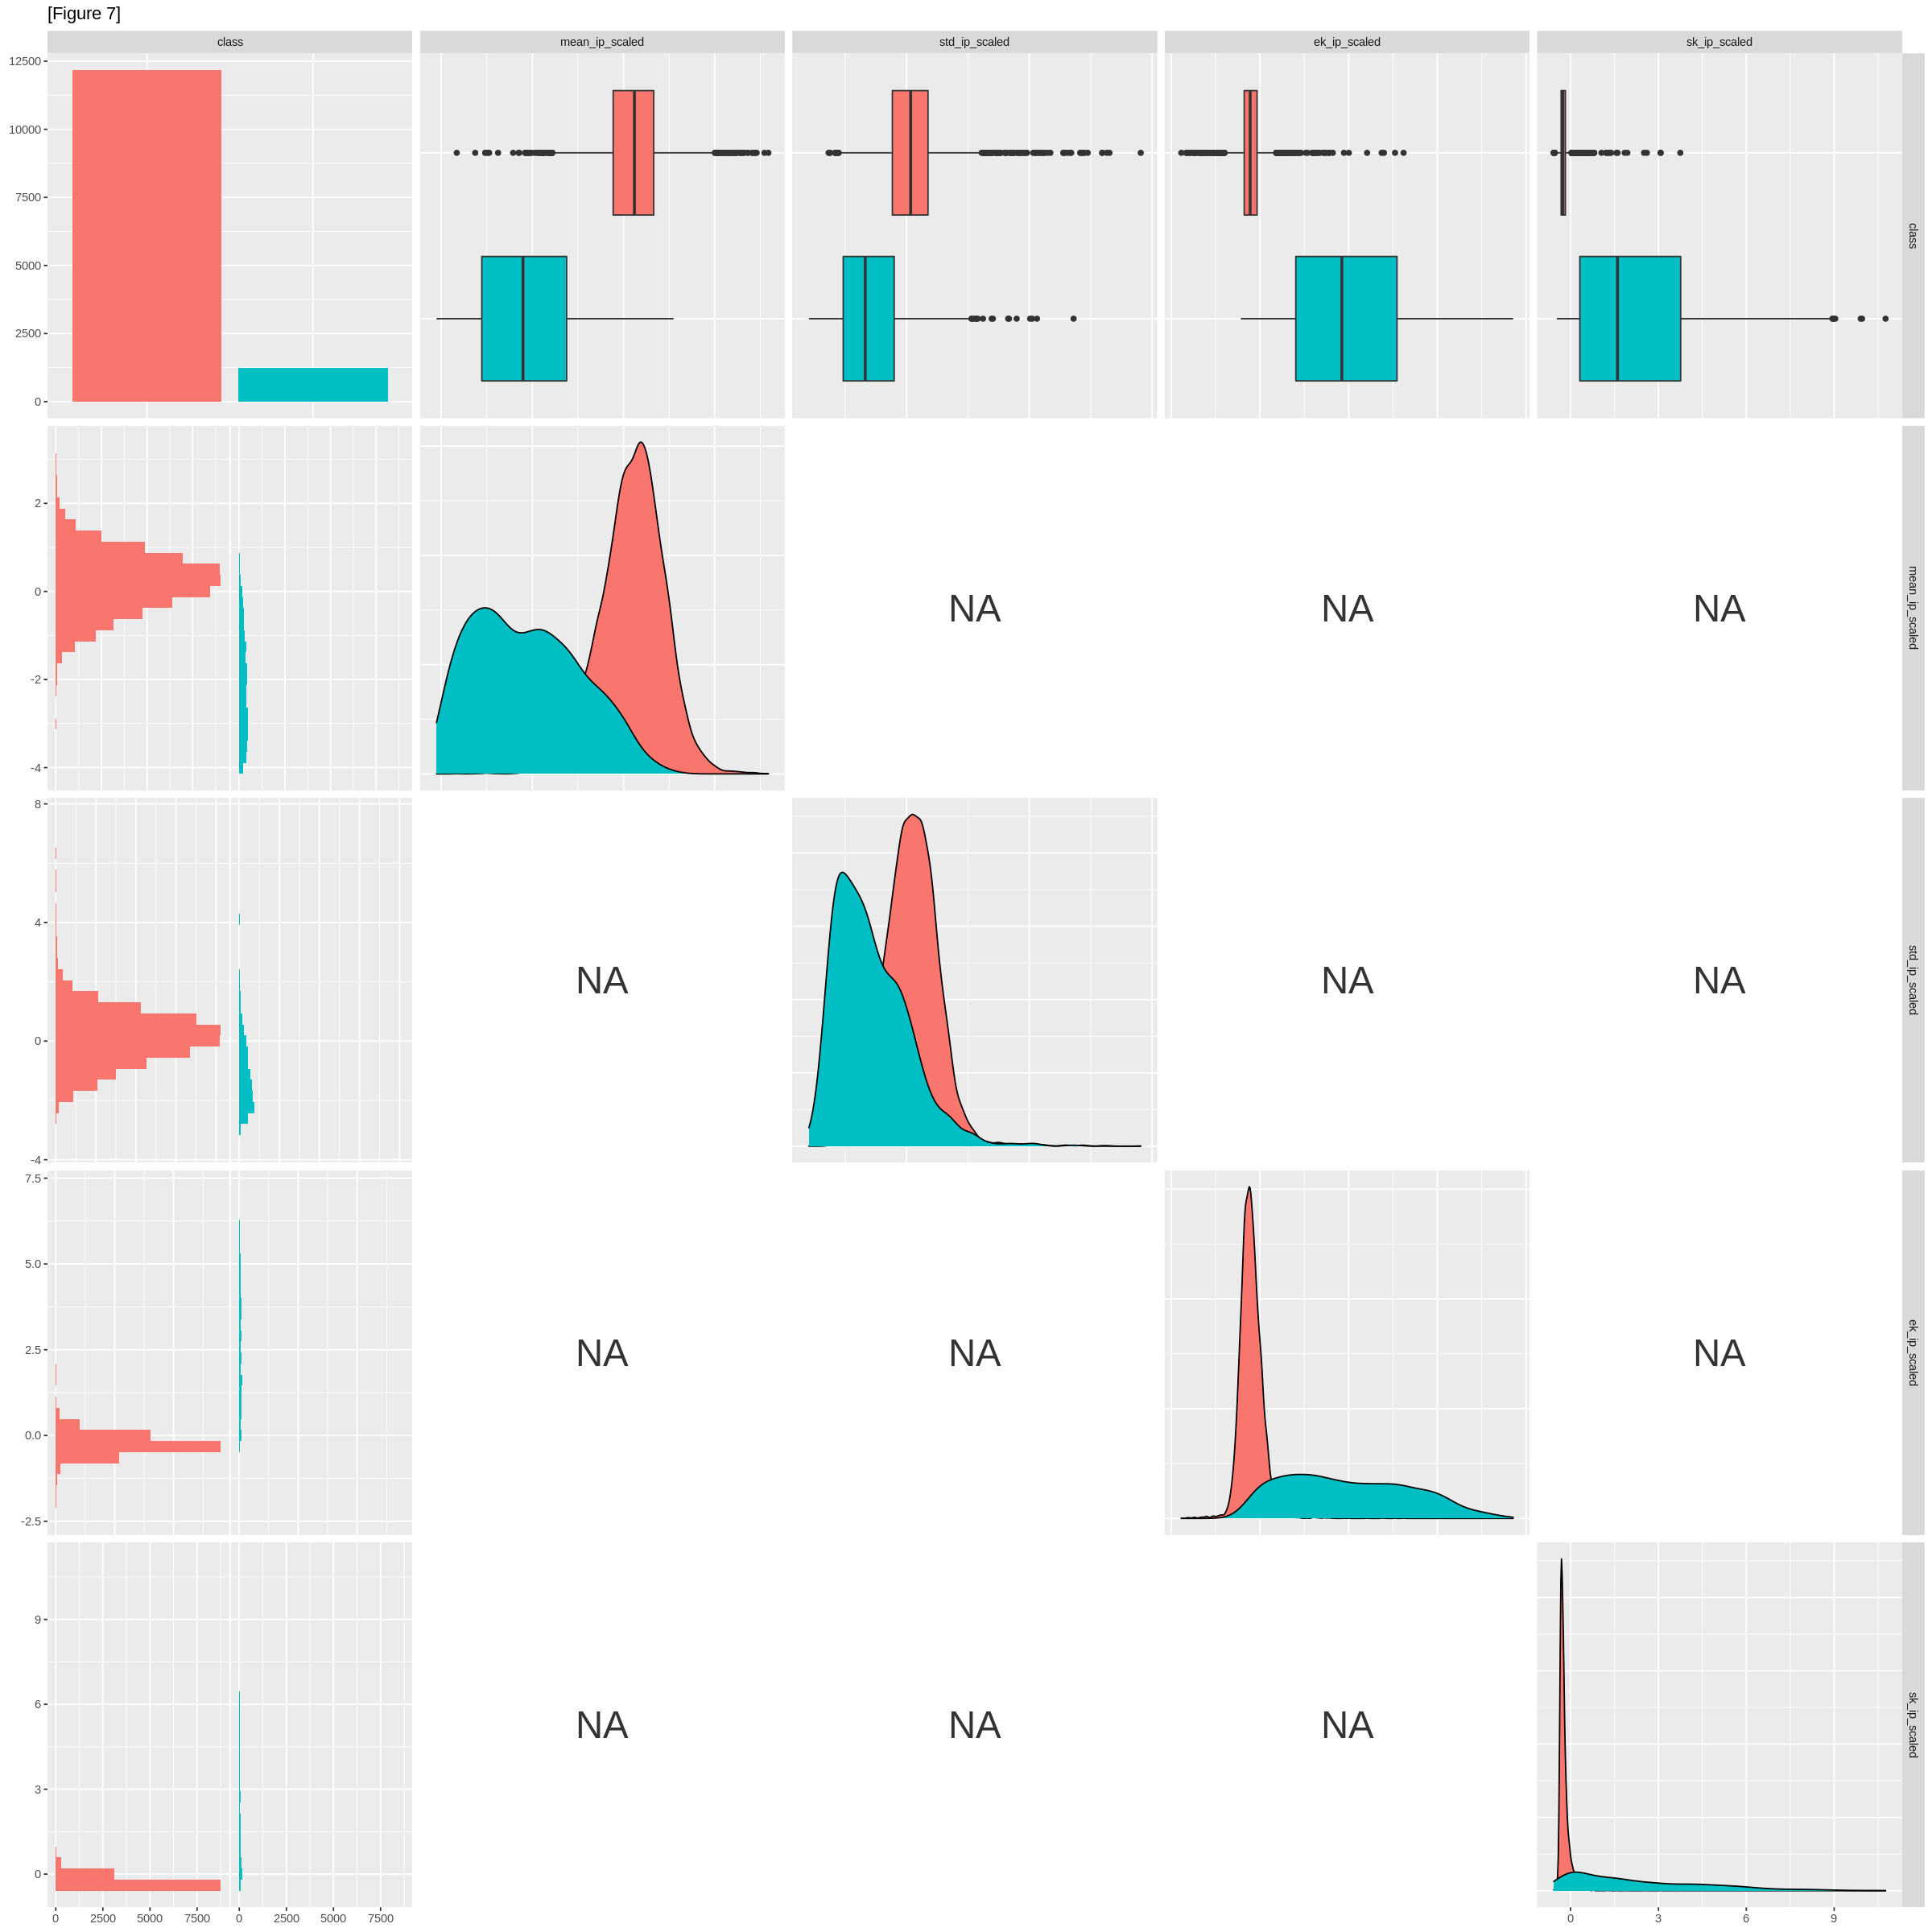

In [11]:
options(repr.plot.width = 20, repr.plot.height = 20)

pairs_plot <- pulsar_training |>
                ggpairs(aes(color=class)) +
                ggtitle("[Figure 7]")
                labs(color=class) +
                theme(text=element_text(size=30))
 
pairs_plot

### Analyzing the graphs and choosing the final predictor variables

In the plots above, we see that the scatters of all the predictors have minuscule overlap between our two classes. Thus, we can go ahead and choose all four of these as our final predictor variables, namely mean_ip, std_ip, ek_ip and sk_ip. Even the box plots in the second image show that the overlap between the two classes for the same variable are very small and that these four predictors should be ideal for training our model with. We want to decrease the overlap between the two classes for all variables as to get more distinct and significant predictors. 

Moreover, we notice in the top right bar graph of the second image between the two classes that the class 1 has very few instances compared to class 2. This rarity of class 1 can make the model more biased towards predicting the class 0 more, thus we will have to fix this issue by upsampling the class 1.

## Training the model

Now, we use $K$-nearest neighbors classification and cross validation of 5 folds in order to train our data. Firstly, we will tune the number of neighbors to find the ideal value for $K$. We will thus test for all values of $K$ from 1 to 100 in steps of 10.

In [12]:
pulsar_upsampled_recipe <- recipe(class ~ mean_ip_scaled, std_ip_scaled, ek_ip_scaled, sk_ip_scaled, data=pulsar_training) |>
                              step_upsample(class, over_ratio=1, skip=FALSE) |>
                              prep()

pulsar_upsampled <- bake(pulsar_upsampled_recipe, pulsar_training)

pulsar_recipe <- recipe(class ~ mean_ip_scaled, std_ip_scaled, ek_ip_scaled, sk_ip_scaled, data=pulsar_upsampled) |>
                    step_scale(all_predictors()) |>  
                    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

pulsar_vfold <- vfold_cv(pulsar_upsampled, v=5, strata=class)

gridvals <- tibble(neighbors=seq(from=1, to=100, by=10))

pulsar_workflow <- workflow() |>
                       add_recipe(pulsar_recipe) |>
                       add_model(knn_tune) |>
                       tune_grid(resamples=pulsar_vfold, grid=gridvals) |>
                       collect_metrics()

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [13]:
classes_in_upsampled <- pulsar_upsampled |>
                            group_by(class) |>
                            summarize(count = n())

print("Table 7")
classes_in_upsampled

[1] "Table 7"


class,count
<fct>,<int>
0,12182
1,12182


Above we see in the tibble that the classes are now balanced, and we have tested for various values of $K$. Next, we collect the accuracy metrics and then plot them against the $K$ values in order to find the most suitable value for our model.

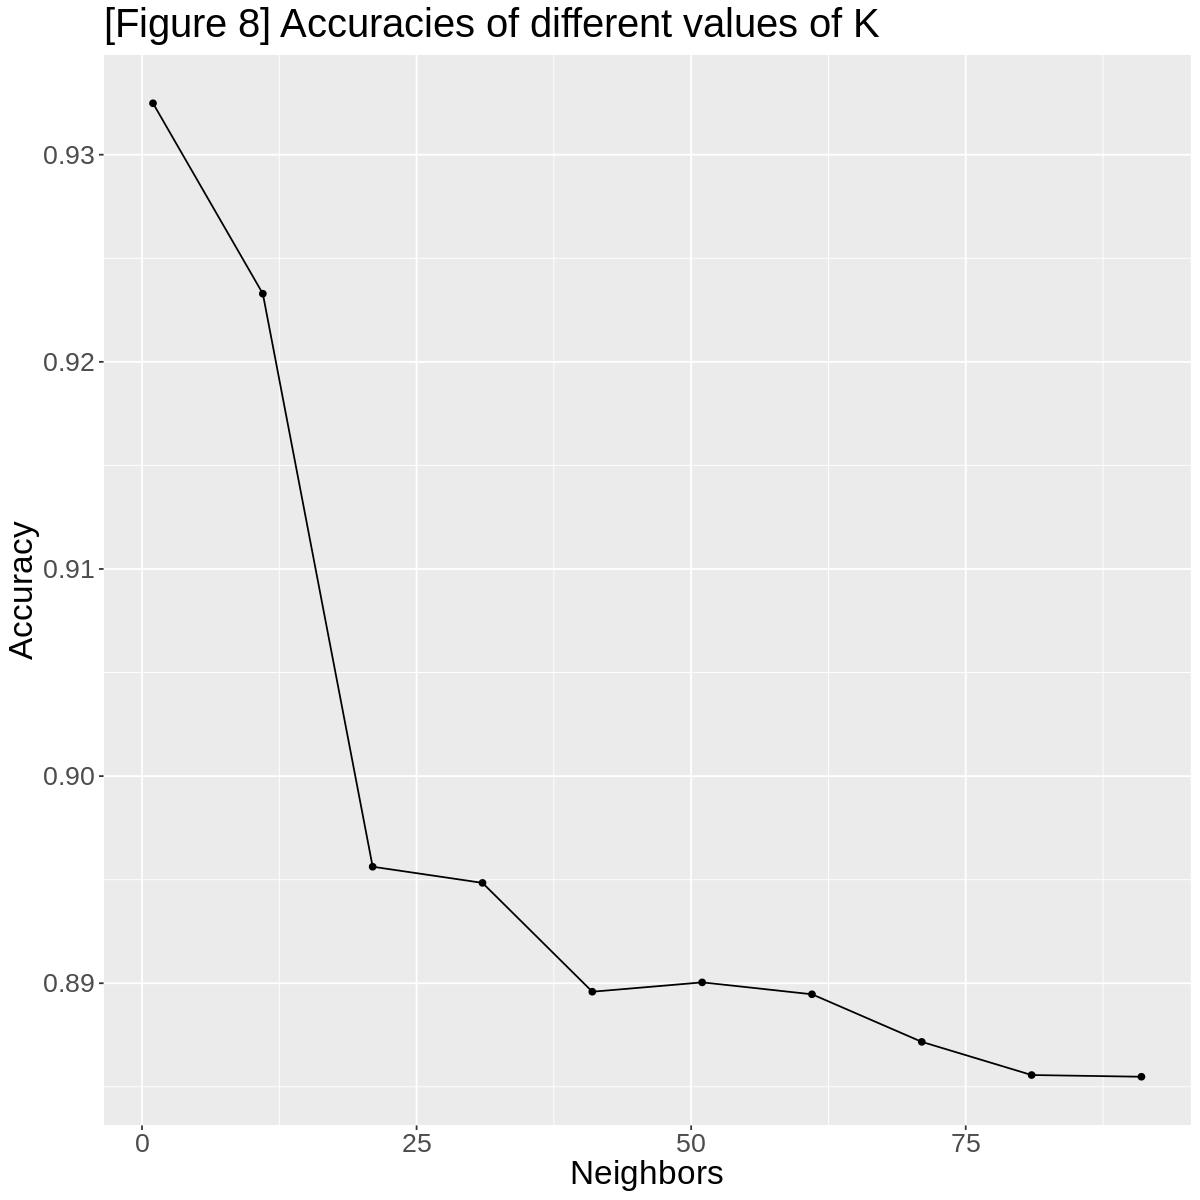

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10)

accuracies <- pulsar_workflow |>
                  filter(.metric == "accuracy") |>
                  select(neighbors, mean)

accuracy_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
                     geom_line() +
                     geom_point() +
                     labs(x = "Neighbors", y = "Accuracy", 
                          title = "[Figure 8] Accuracies of different values of K") +
                     theme(text = element_text(size = 20))

accuracy_plot

Above, we see that the accuracy is the highest for the values of $K$ between 0 and 20. Thus, we can test for values for $K$ between 0 and 20 using smaller intervals to get a better and more precise value.

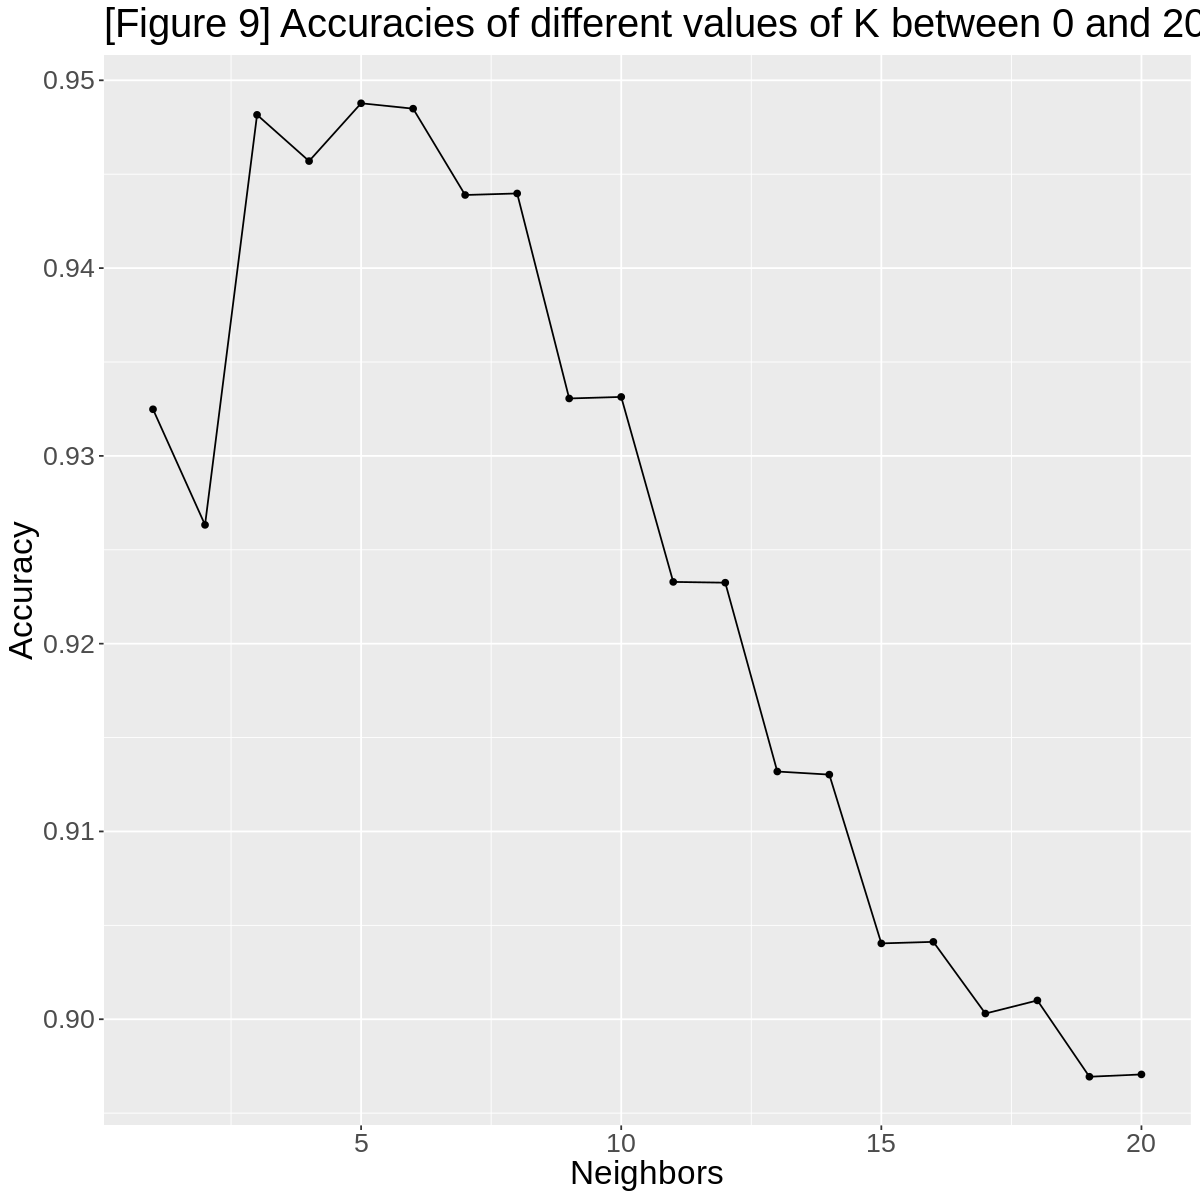

In [15]:
options(repr.plot.width = 10, repr.plot.height = 10)

gridvals2 <- tibble(neighbors=seq(from=1, to=20, by=1))

pulsar_workflow_2 <- workflow() |>
                       add_recipe(pulsar_recipe) |>
                       add_model(knn_tune) |>
                       tune_grid(resamples=pulsar_vfold, grid=gridvals2) |>
                       collect_metrics()

accuracies2 <- pulsar_workflow_2 |>
                  filter(.metric == "accuracy") |>
                  select(neighbors, mean)

accuracy_plot_2 <- ggplot(accuracies2, aes(x=neighbors, y=mean)) +
                     geom_line() +
                     geom_point() +
                     labs(x = "Neighbors", y = "Accuracy", 
                          title = "[Figure 9] Accuracies of different values of K between 0 and 20") +
                     theme(text = element_text(size = 20))

accuracy_plot_2

Now we see that the maximum accuracy occurs when $K$ is 5. Thus, we can go ahead using this value of $K$ with the same model.

In [16]:
knn_tune_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
                set_engine("kknn") |>
                set_mode("classification")

pulsar_fit <- workflow() |>
                add_recipe(pulsar_recipe) |>
                add_model(knn_tune_2) |>
                fit(data = pulsar_upsampled)

Now, we are ready to predict the class labels for our test set.

## Making the predictions

In [17]:
pulsar_predictions <- predict(pulsar_fit , pulsar_testing) |>
       bind_cols(pulsar_testing)


print("Table 8")
head(pulsar_predictions)

[1] "Table 8"


.pred_class,class,mean_ip_scaled,std_ip_scaled,ek_ip_scaled,sk_ip_scaled
<fct>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0,0,-0.31436338,-1.05329280,-0.14522850,-0.1165896
0,0,-0.68255954,0.02171238,0.05079471,-0.2194515
0,0,0.86453436,-0.36405361,-0.52527844,-0.2683108
0,0,-0.05610833,0.36066817,-0.31974505,-0.3286328
0,0,-0.39719990,0.78046399,0.14062376,-0.2913103
0,0,0.06388281,0.54824415,-0.18652152,-0.3079307


Now, we calculate the accuracy of our predictions.

## Calculating the accuracies

In [18]:
pulsar_accuracy <- pulsar_predictions |>
                     metrics(truth = class, estimate = .pred_class) 

print("Table 9")
pulsar_accuracy

[1] "Table 9"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9197765
kap,binary,0.5869178


Let's have a look at the confusion matrix as well.

In [19]:
pulsar_mat <- pulsar_predictions |> 
                conf_mat(truth = class, estimate = .pred_class)

print("Table 10")
pulsar_mat

[1] "Table 10"


          Truth
Prediction    0    1
         0 3810   92
         1  267  306

## Visualizing our accuracy of our model

We can now try and visualize the accuracy of our predictions by plotting all predictors of the testing data and the predictions to see how similar both are. For this instance, let's just see the comparisons between the plots of mean integrated profile versus the standard deviation of the integrated profile.

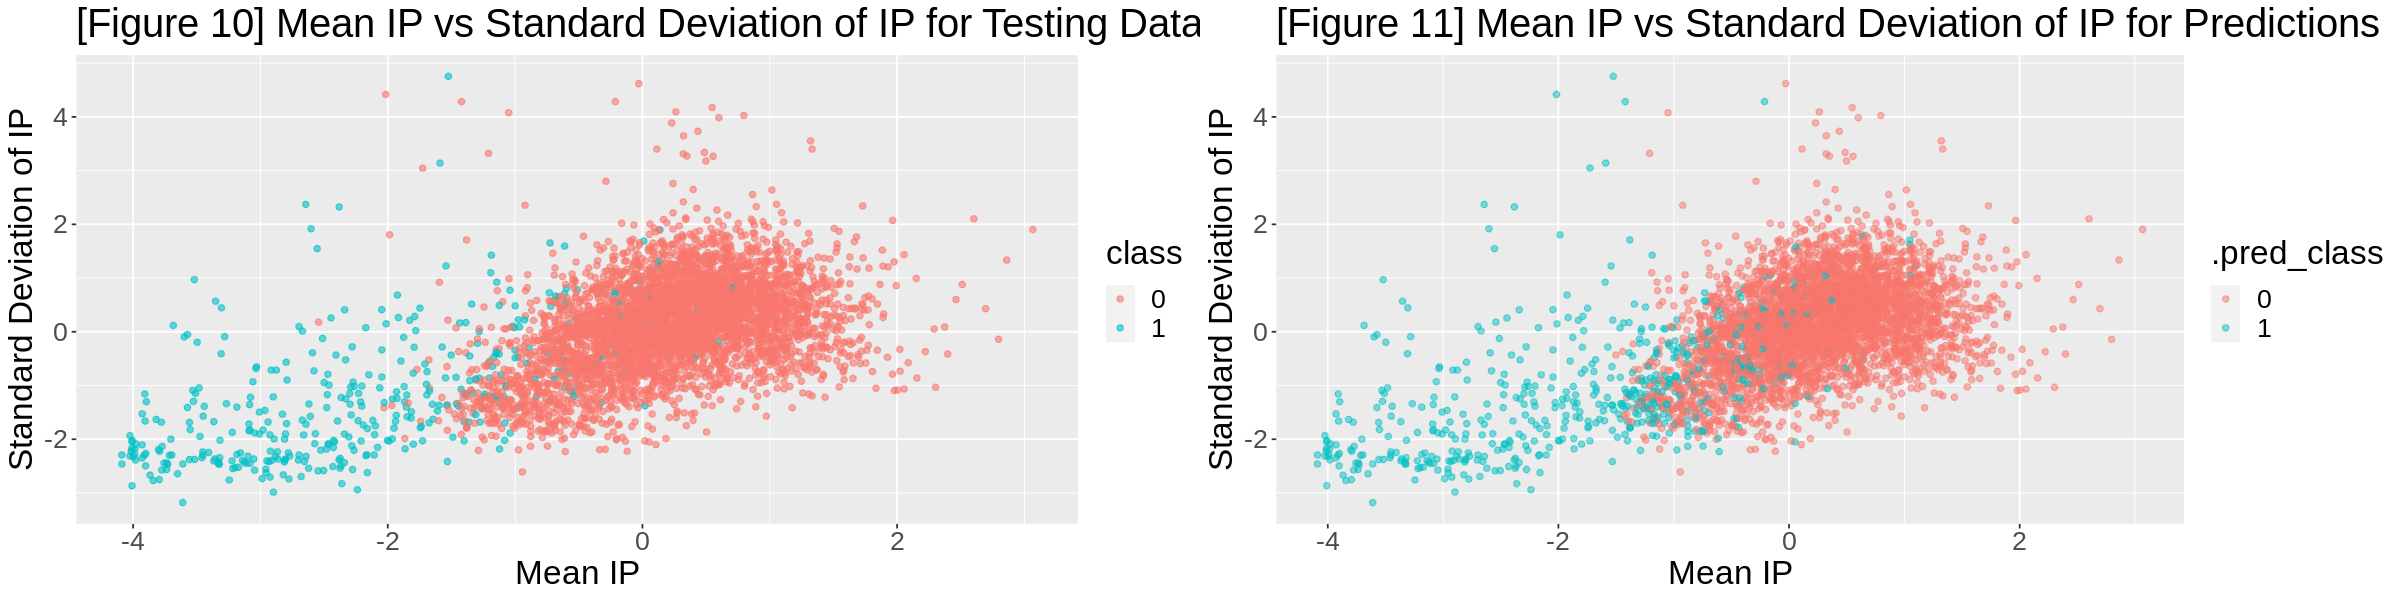

In [20]:
options(repr.plot.width = 20, repr.plot.height = 5)

plot_mean_ip_std_ip_test <- ggplot(pulsar_testing, aes(x=mean_ip_scaled, y=std_ip_scaled, color=class)) + 
                                geom_point(alpha=0.6) + 
                                ggtitle('[Figure 10] Mean IP vs Standard Deviation of IP for Testing Data') +
                                labs(x= 'Mean IP', y= 'Standard Deviation of IP') +
                                theme(text=element_text(size=20))

plot_mean_ip_std_ip_pred <- ggplot(pulsar_predictions, aes(x=mean_ip_scaled, y=std_ip_scaled, color=.pred_class)) + 
                                geom_point(alpha = 0.5) + 
                                ggtitle('[Figure 11] Mean IP vs Standard Deviation of IP for Predictions') +
                                labs(x= 'Mean IP', y= 'Standard Deviation of IP') +
                                theme(text=element_text(size=20))

plot_grid(plot_mean_ip_std_ip_test, plot_mean_ip_std_ip_pred)

Now comparing the plots between Excess Kurtosis and Mean.

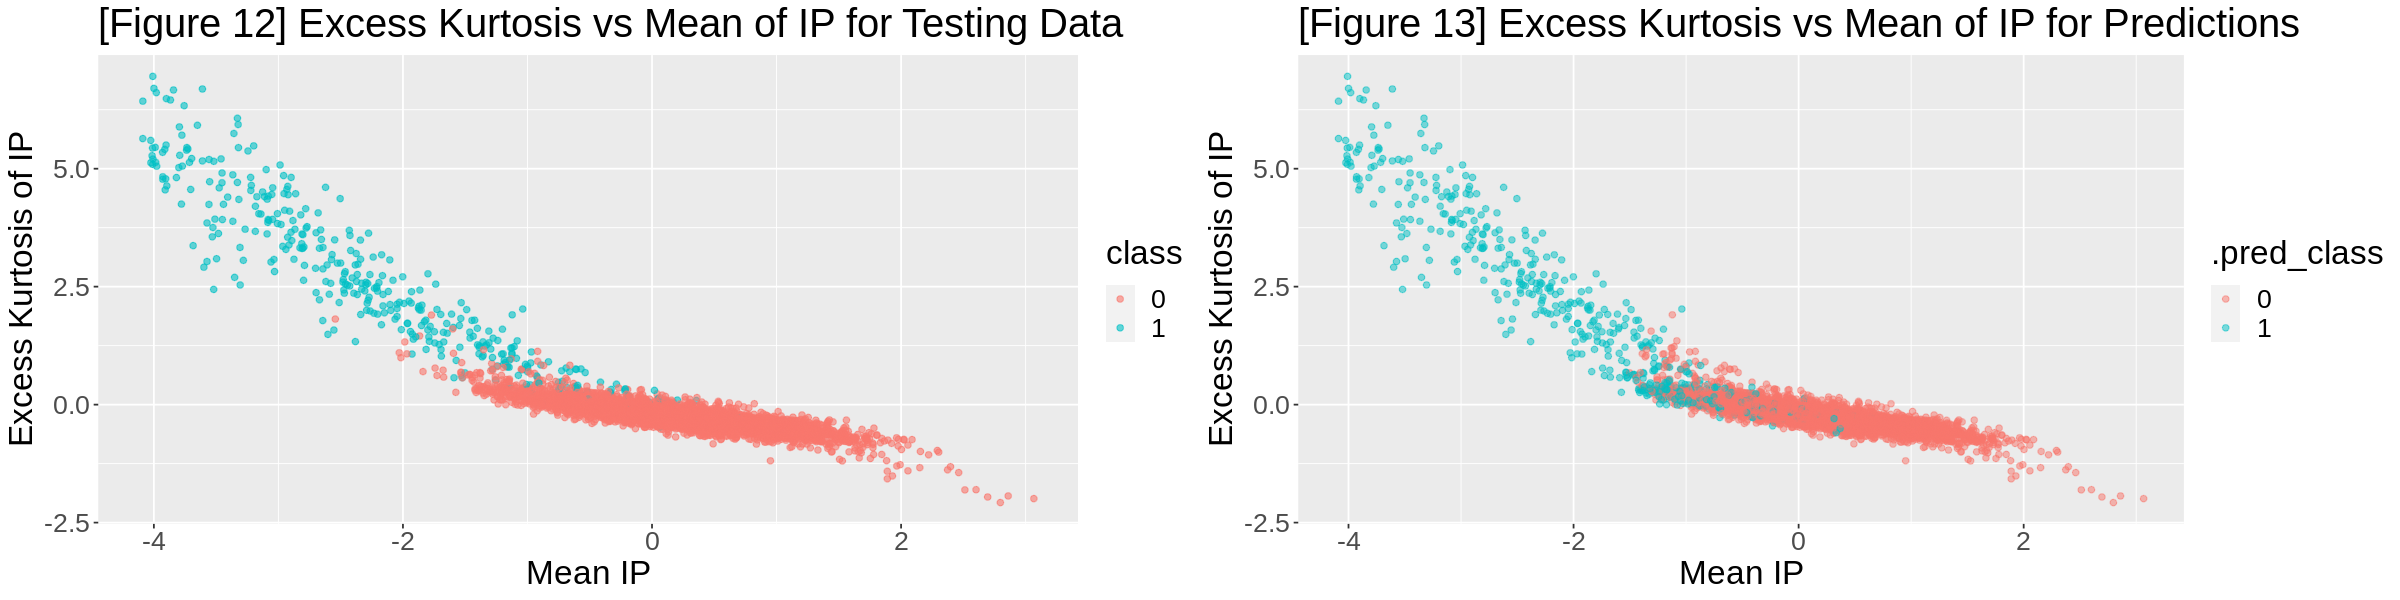

In [21]:
options(repr.plot.width = 20, repr.plot.height = 5)

plot_mean_ip_ek_ip_test <- ggplot(pulsar_testing, aes(x=mean_ip_scaled, y=ek_ip_scaled, color=class)) + 
                                geom_point(alpha=0.6) + 
                                ggtitle('[Figure 12] Excess Kurtosis vs Mean of IP for Testing Data') +
                                labs(x= 'Mean IP', y= 'Excess Kurtosis of IP') +
                                theme(text=element_text(size=20))

plot_mean_ip_ek_ip_pred <- ggplot(pulsar_predictions, aes(x=mean_ip_scaled, y=ek_ip_scaled, color=.pred_class)) + 
                                geom_point(alpha = 0.5) + 
                                ggtitle('[Figure 13] Excess Kurtosis vs Mean of IP for Predictions') +
                                labs(x= 'Mean IP', y= 'Excess Kurtosis of IP') +
                                theme(text=element_text(size=20))

plot_grid(plot_mean_ip_ek_ip_test, plot_mean_ip_ek_ip_pred)

Now comparing the plots between Skewness and Mean.

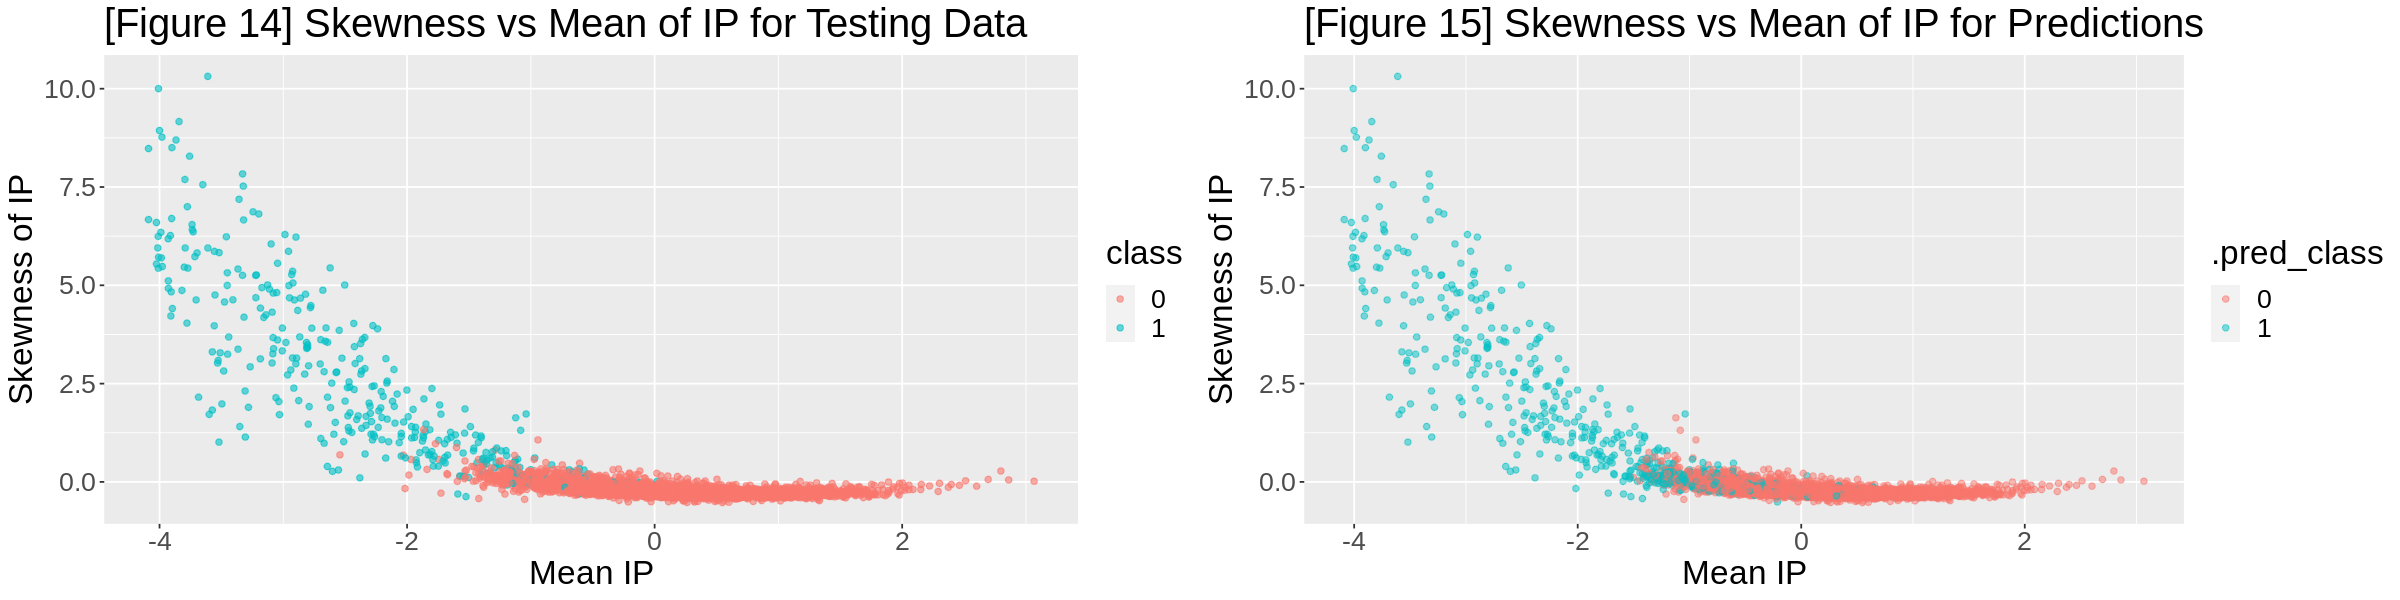

In [22]:
options(repr.plot.width = 20, repr.plot.height = 5)

plot_mean_ip_sk_ip_test <- ggplot(pulsar_testing, aes(x=mean_ip_scaled, y=sk_ip_scaled, color=class)) + 
                                geom_point(alpha=0.6) + 
                                ggtitle('[Figure 14] Skewness vs Mean of IP for Testing Data') +
                                labs(x= 'Mean IP', y= 'Skewness of IP') +
                                theme(text=element_text(size=20))

plot_mean_ip_sk_ip_pred <- ggplot(pulsar_predictions, aes(x=mean_ip_scaled, y=sk_ip_scaled, color=.pred_class)) + 
                                geom_point(alpha = 0.5) + 
                                ggtitle('[Figure 15] Skewness vs Mean of IP for Predictions') +
                                labs(x= 'Mean IP', y= 'Skewness of IP') +
                                theme(text=element_text(size=20))

plot_grid(plot_mean_ip_sk_ip_test, plot_mean_ip_sk_ip_pred)

## Methods

For this project, we decided to use $K$-nearest neighbors classification.

First, we read the data straight from the web that provided the Pulsar Star data and store it a reference to locally to work upon it.

To make the predictor model, we first have to make our data ready for processing. The data given was in two basic sets: Integrated Profile and DM-SNR curve. We selected the Integrated Profile set because both of these sets consist of similar measurements but in different forms, thus training the model on both sets would be redundant. Moreover, when making a ggpairs plot with all the predictors, we saw that the Integrated Profile predictors had very less overlap between the two classes, thus making them ideal for using to train our model. Then we scaled the data around the center for the predictor columns, so that the difference in the scale of all the predictors does not negatively affect the accuracy of the $K$-nn classification model which is based on the Euclidean distance between datapoints. Then we split this data by into the training and the testing set by 75% and 25%, respectively.

Now working with our training set we check for any missing data which could increase complications down the line, luckily there were none. While analyzing our data, we saw that only 9.2% of the data set was made up of pulsars so we oversampled it so that the ratio of pulsars to non-pulsars was 1:1.

After this we used $K$-nearest neighbors classification with cross validation of 5 folds on our data using $K$ from 1 to 100 in steps of 10. After getting the accuracy or each $K$, we observed that the highest accuracy was between 1 and 20, thus we ran it again but with $K$ from 1 to 20 with steps of 1. Again, we plotted the accuracies and found the height accuracy to be at $K = 5$.

Now we trained out model with $K$ set to 5. We used the model against our testing data and obtained an accuracy of approximately 92%. We further visualized our results by comparing the predicted class (pulsar/non-pulsar) against the true class.

## Discussions

The aim of this study is to investigate the predictors that are important for identifying pulsars and predicting their presence based on their Integrated Profile statistics. 

After analyzing the dataset, it was found that four predictors, Mean, Standard Deviation, Excess Kurtosis, and Skewness of the Integrated Profile provide unique information on their intrinsic relationship with each observation to varying degrees. The model's accuracy was finally found to be 92%, which was higher than expected, indicating that the chosen predictors are crucial in predicting the presence of pulsars based on integrated profile statistics. The unexpectedly high accuracy might also be the result of us up-sampling our class column which mitigated the issue of one class being rare as compared to the other class, and also the fact that we fine tuned the value of $K$ by testing for various different values and finding the final value which gave the best possible results for us.

The findings of this study have important implications for future research, as they provide fundamental knowledge for analyzing the most important properties of pulsars and for designing effective classification models. Furthermore, the high accuracy of the model leads to questions for future research, such as the classification of other neutron stars, such as magnetars or lower magnitude stars. Moreover, here we are predicting if an observation is a pulsar or not, but in the future we could try and predict more in-depth details of pulsars, such as their age or origin. In conclusion, the findings of this study provide valuable insights into the importance of integrated profile statistics in the identification of pulsars and highlight the potential for further research to improve our understanding of these fascinating celestial objects.



## References

Dataset:
- R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656
https://archive.ics.uci.edu/ml/datasets/HTRU2

Papers:
- R. J. Lyon, 'Why Are Pulsars Hard To Find?', PhD Thesis, University of Manchester, 2016.
- D. R. Lorimer and M. Kramer, 'Handbook of Pulsar Astronomy', Cambridge University Press, 2005.